# Zadanie 8.2 (5 pkt + BONUS)
### Deadline 13.01 o 23:59

Na podstawie danych zawartych w zbiorze https://www.kaggle.com/mlg-ulb/creditcardfraud 
dotyczącym wyłudzeń transakcji kartowych, stwórz model drzewa decyzyjnego oraz lasu losowego, 
który szacować będzie ryzyko wyłudzenia.

W zadaniu muszą pojawić się co najmniej takie punkty jak:
- Podział zbioru na treningowy i testowy
- Ocena jakości każdego z modeli oraz wybór lepszego z nich.
- Wybór poziomu cut-off, który pozwoli na jak najlepsze wykrywanie fraudów 

(Zastanów się, co jest dla Ciebie gorszą sytuacją błędne przypisanie frauda zwykłej transakcji czy uznanie zwykłej transakcji za fradu). 
Uargumnetuj swój wybór.

Zadanie dodatkowe (BONUS)   
Fraud jest zdarzeniem rzadkim. Istnieją metody, które pozwalają na lepsze rozpoznanie tego typu zjawisk, mogą to być na przykład oversampling lub undersampling. Użyj jednej z tych metod.

Uwagi:
Zbiór cech jest wynikiem analizy głównych składowych (ang. PCA) - metody zmniejszającej wymiarowość (liczbę cech objaśniających).


In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler,QuantileTransformer,PowerTransformer,Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, plot_confusion_matrix,f1_score, precision_recall_curve, roc_curve
from scipy import stats
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from yellowbrick.model_selection import CVScores
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [29]:
df = pd.read_csv('creditcard.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


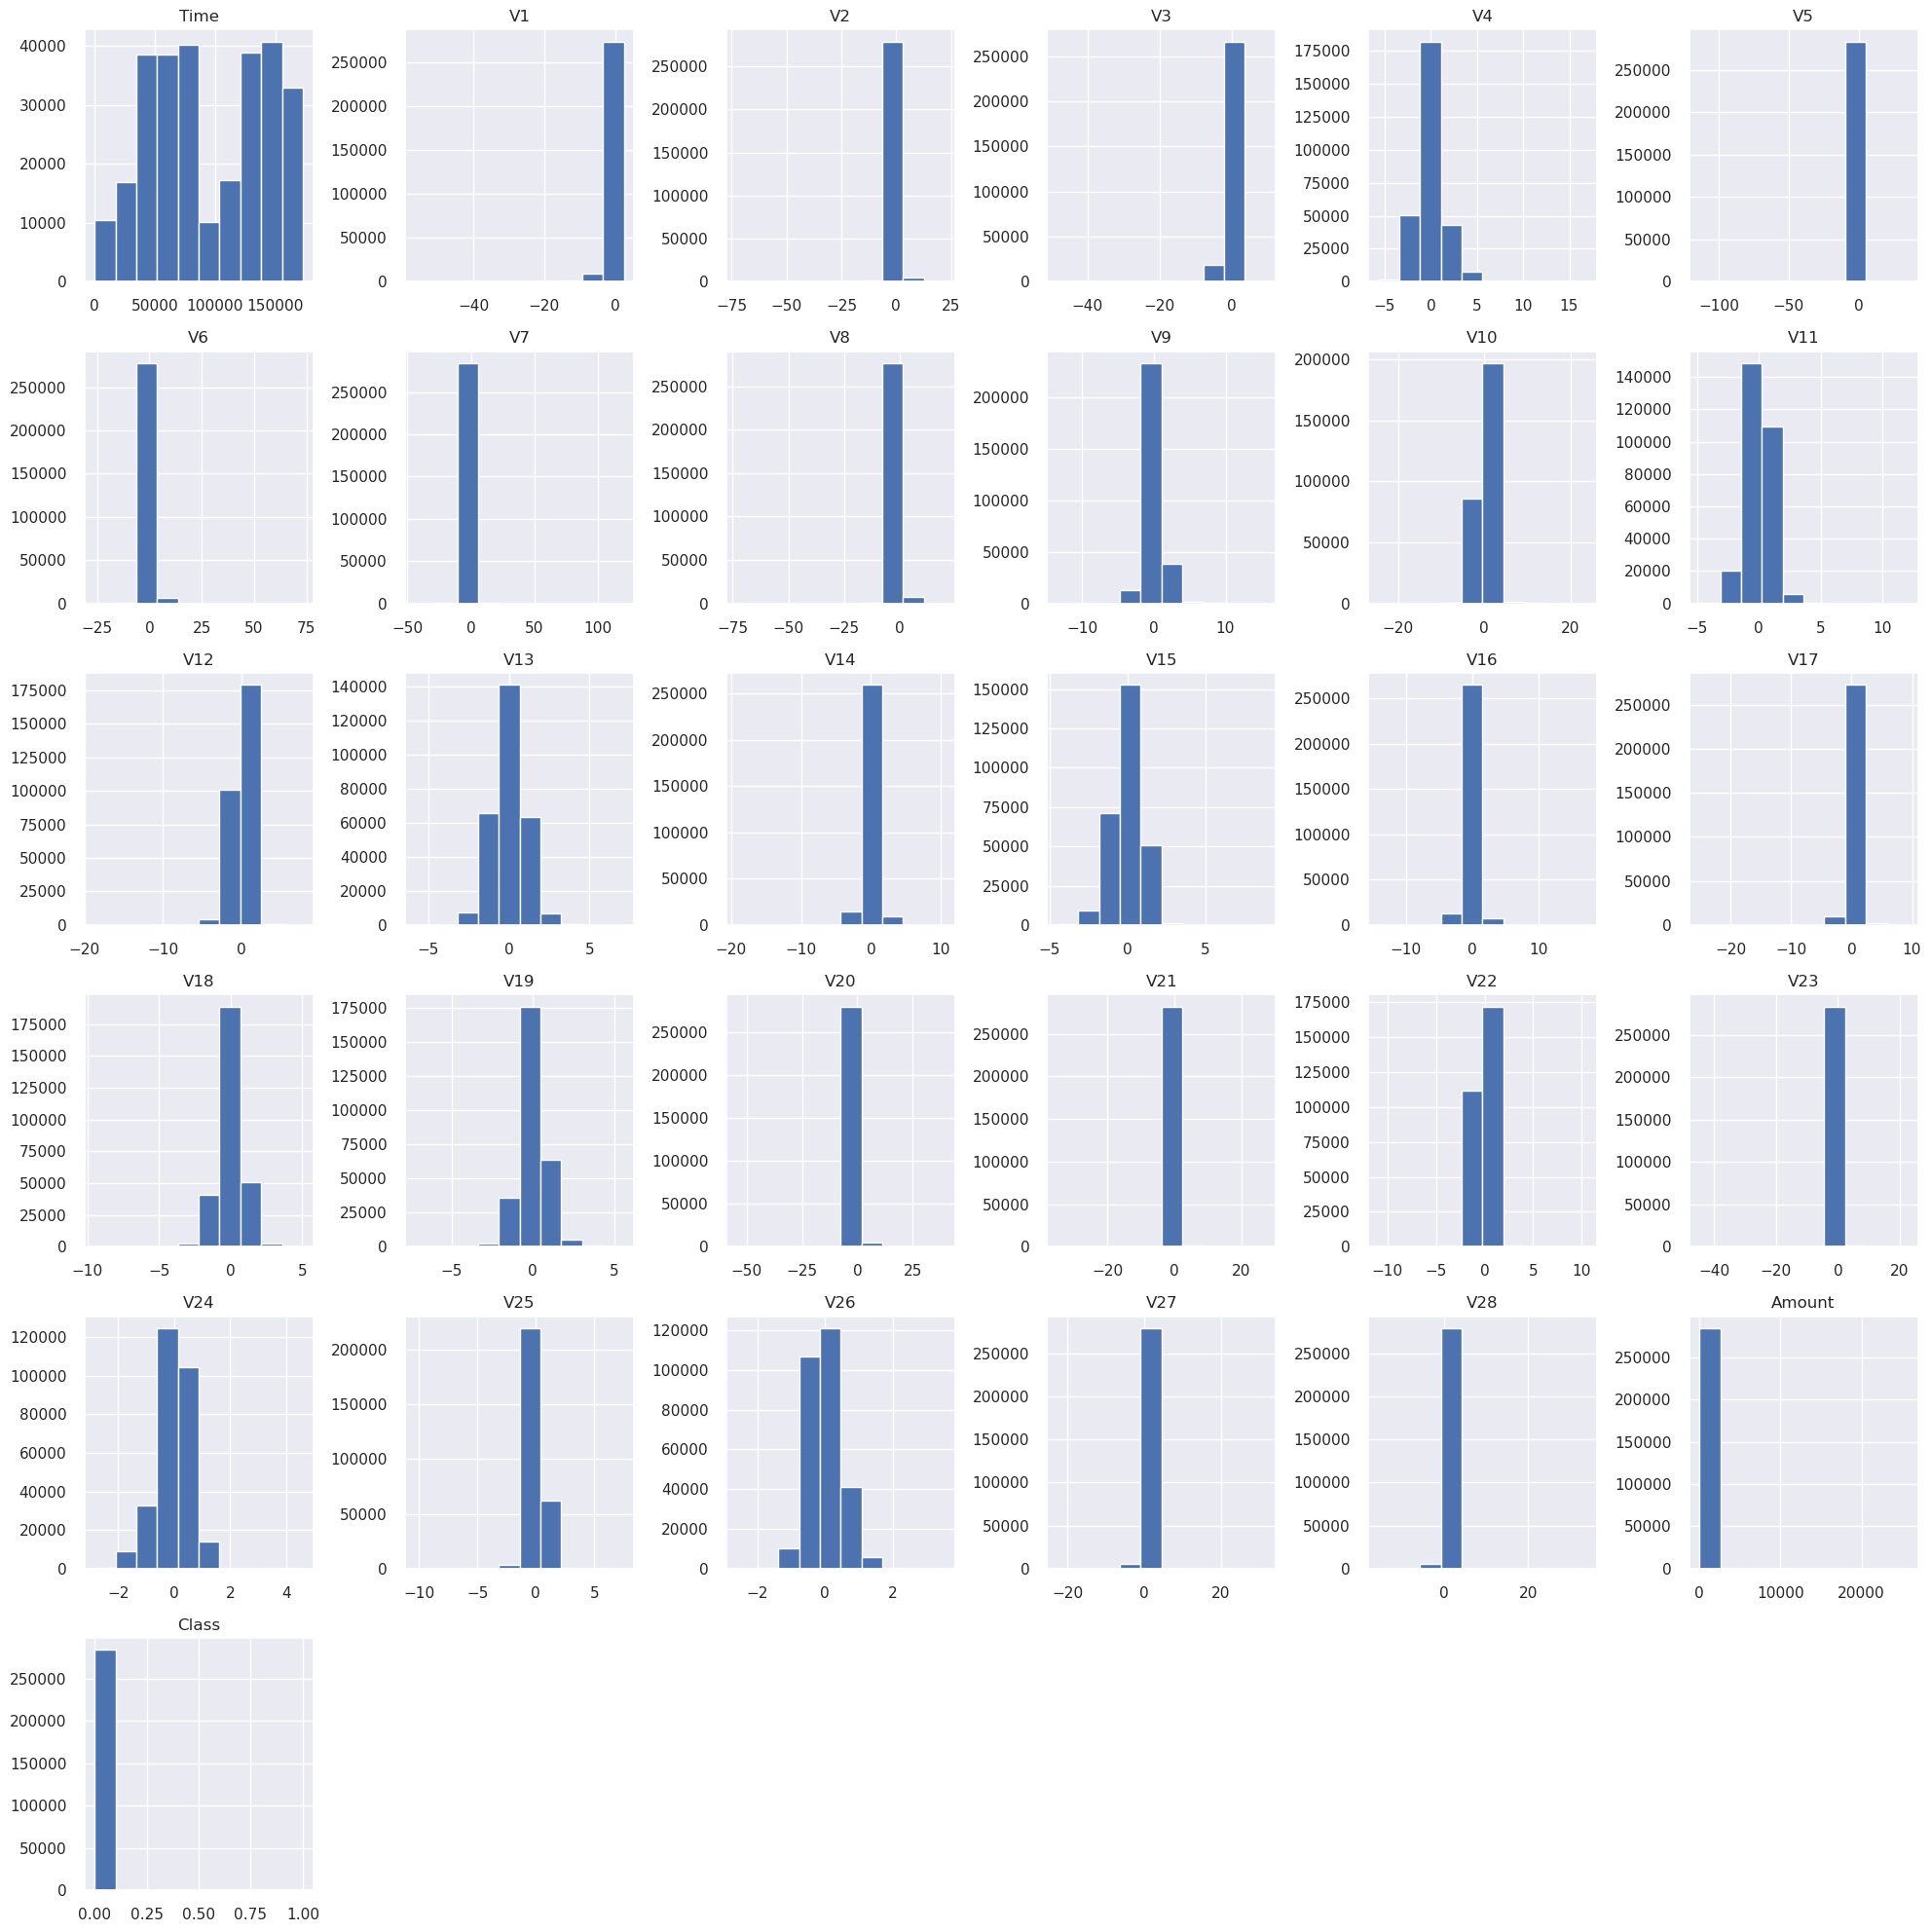

In [30]:
df.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

* Kolumny 'Time' i 'Amount' nie sa wystandaryzowane w przeciwieństwie do zmiennych po transformacji PCA V1-V28

In [17]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [31]:
df.duplicated().sum()

1081

In [32]:
df.drop_duplicates(inplace=True)

In [33]:
# Standaryzacja kolumn:

standard_scaler = StandardScaler()
# robust_scaler = RobustScaler()

df['scaled_amount'] = standard_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = standard_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

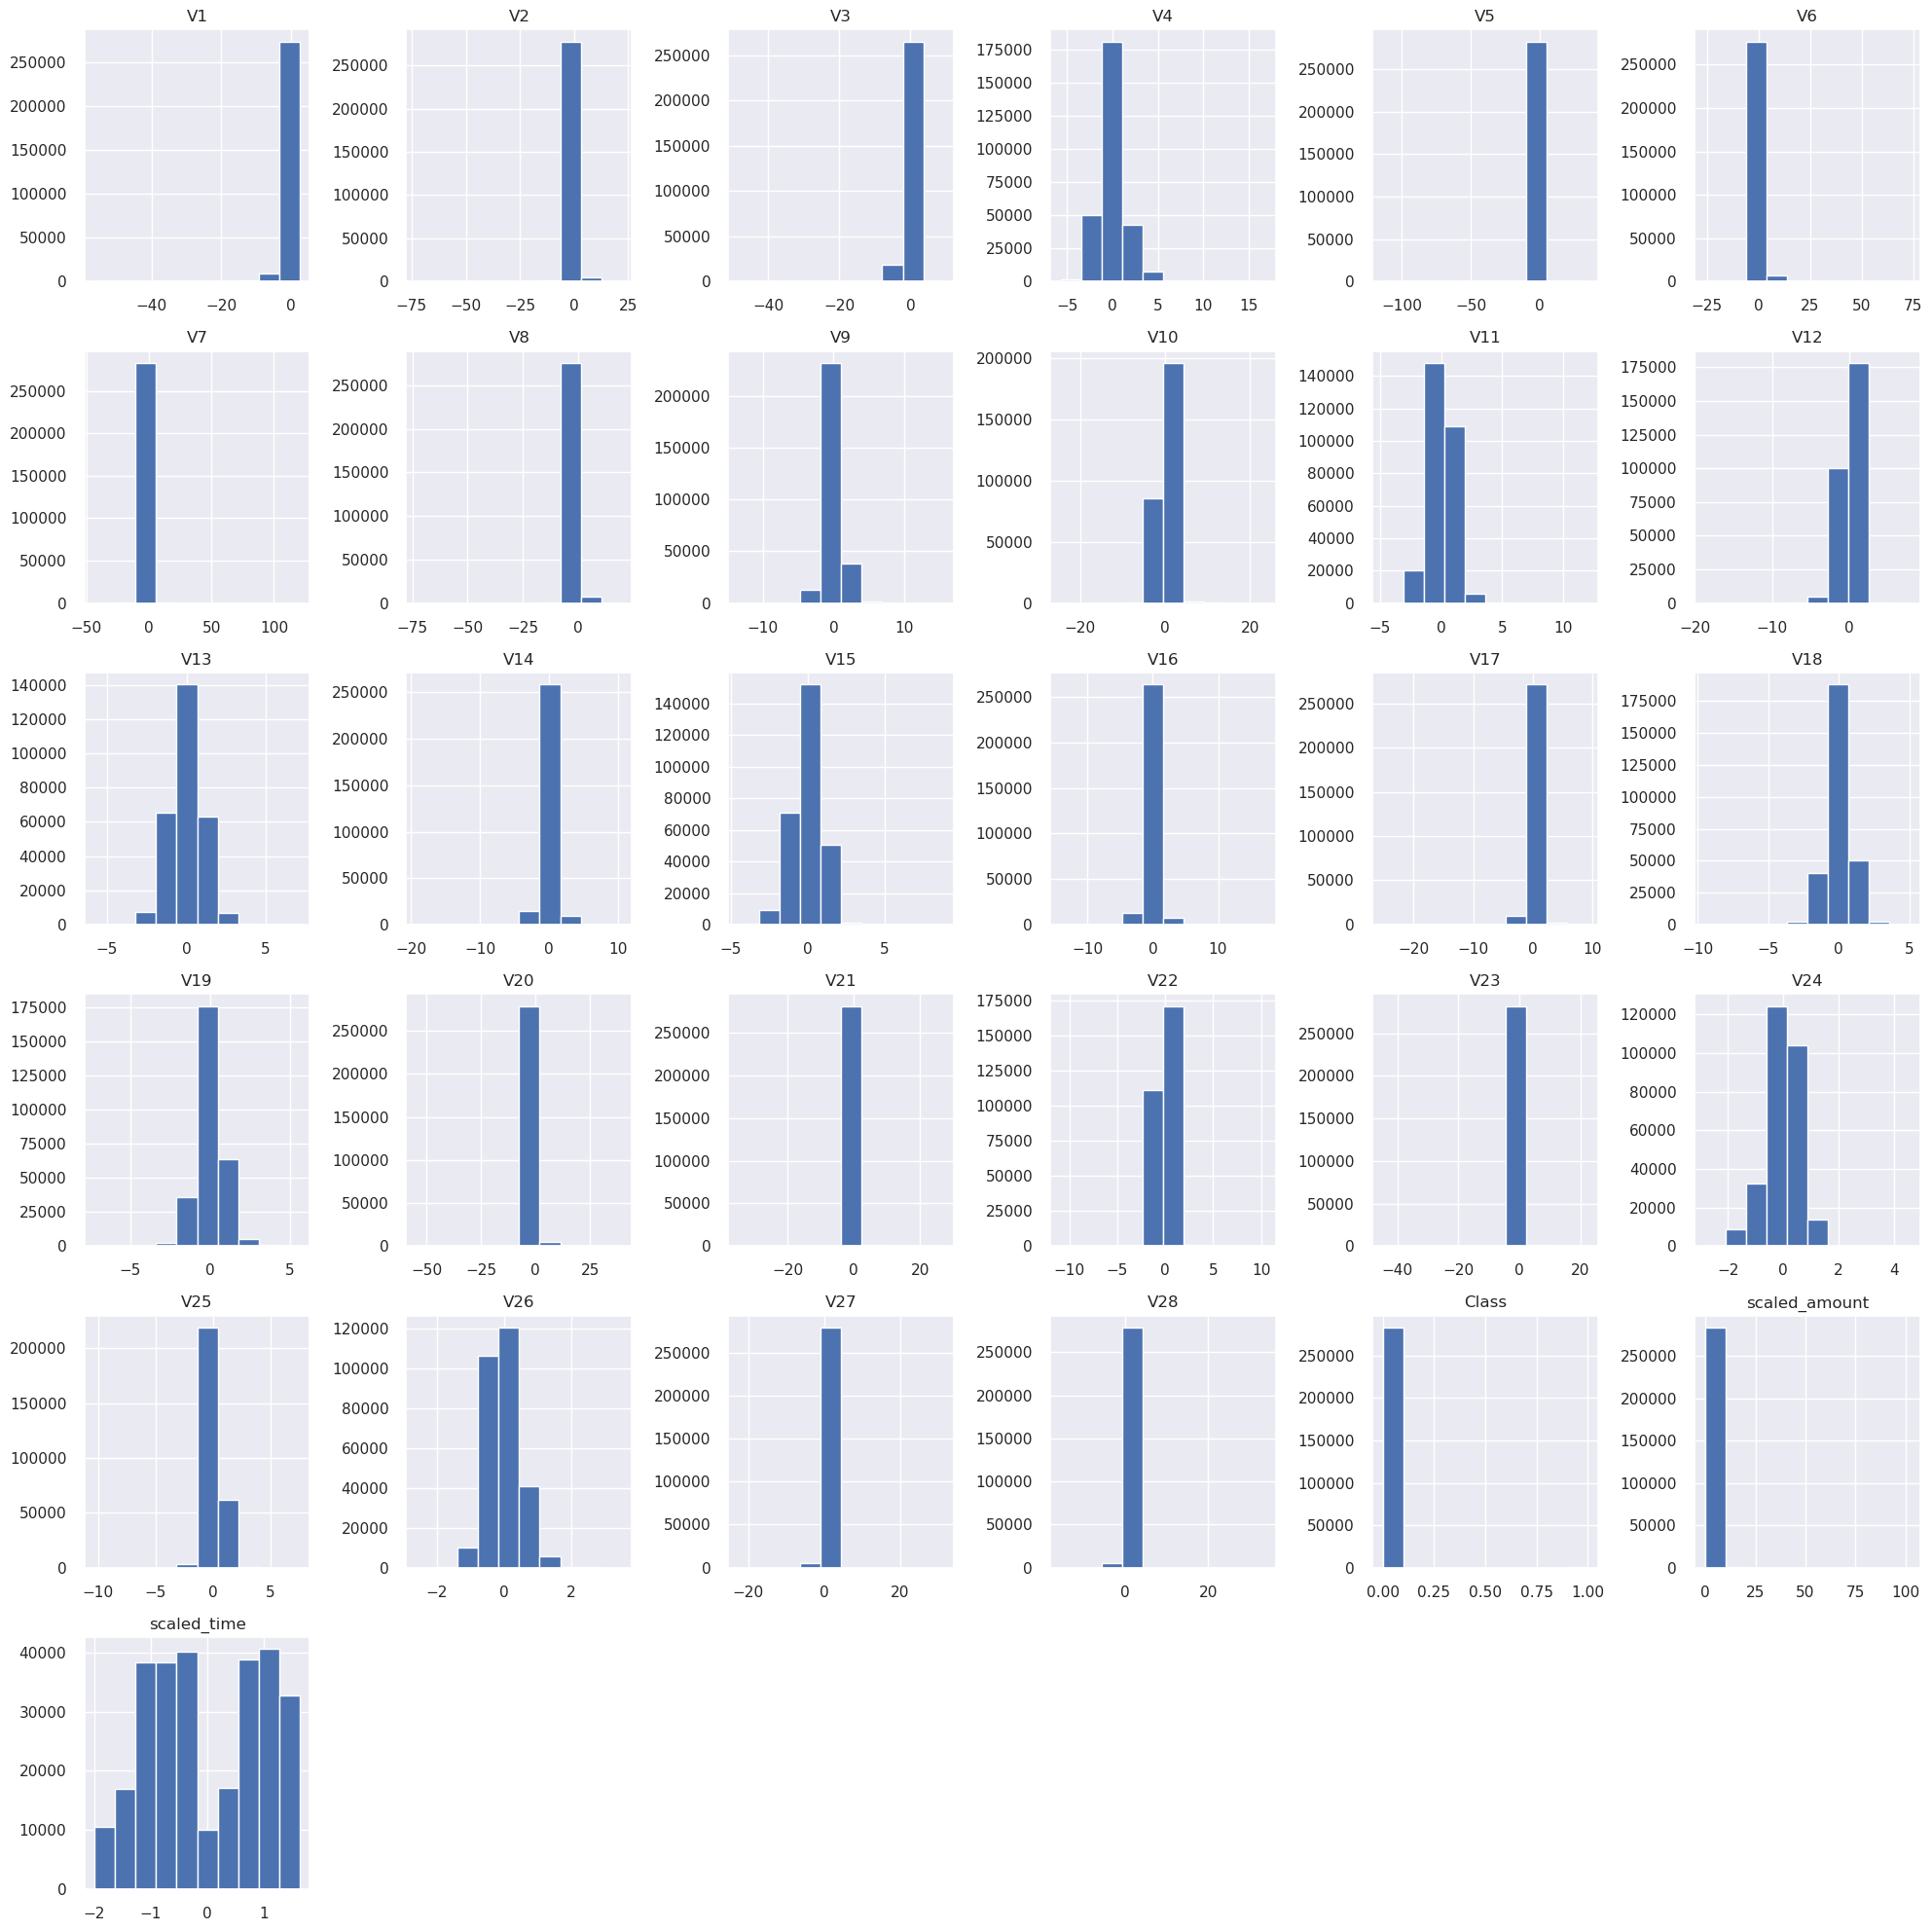

In [34]:
df.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

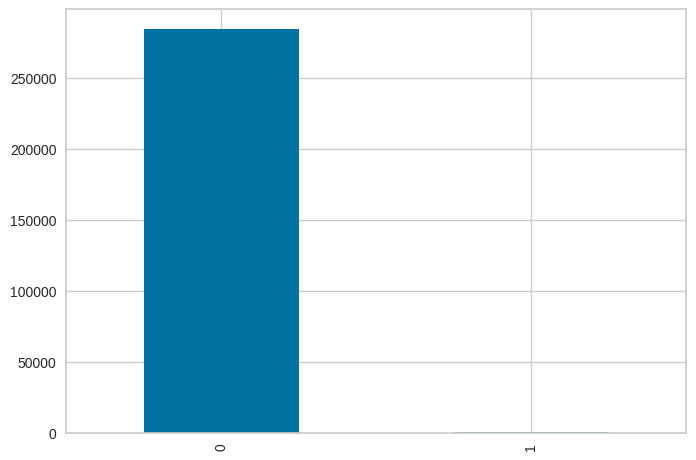

In [12]:
df['Class'].value_counts().plot(kind="bar")
plt.show()

In [13]:
print('No Frauds:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '%')
print('Frauds:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '%')

No Frauds: 99.83 %
Frauds: 0.17 %


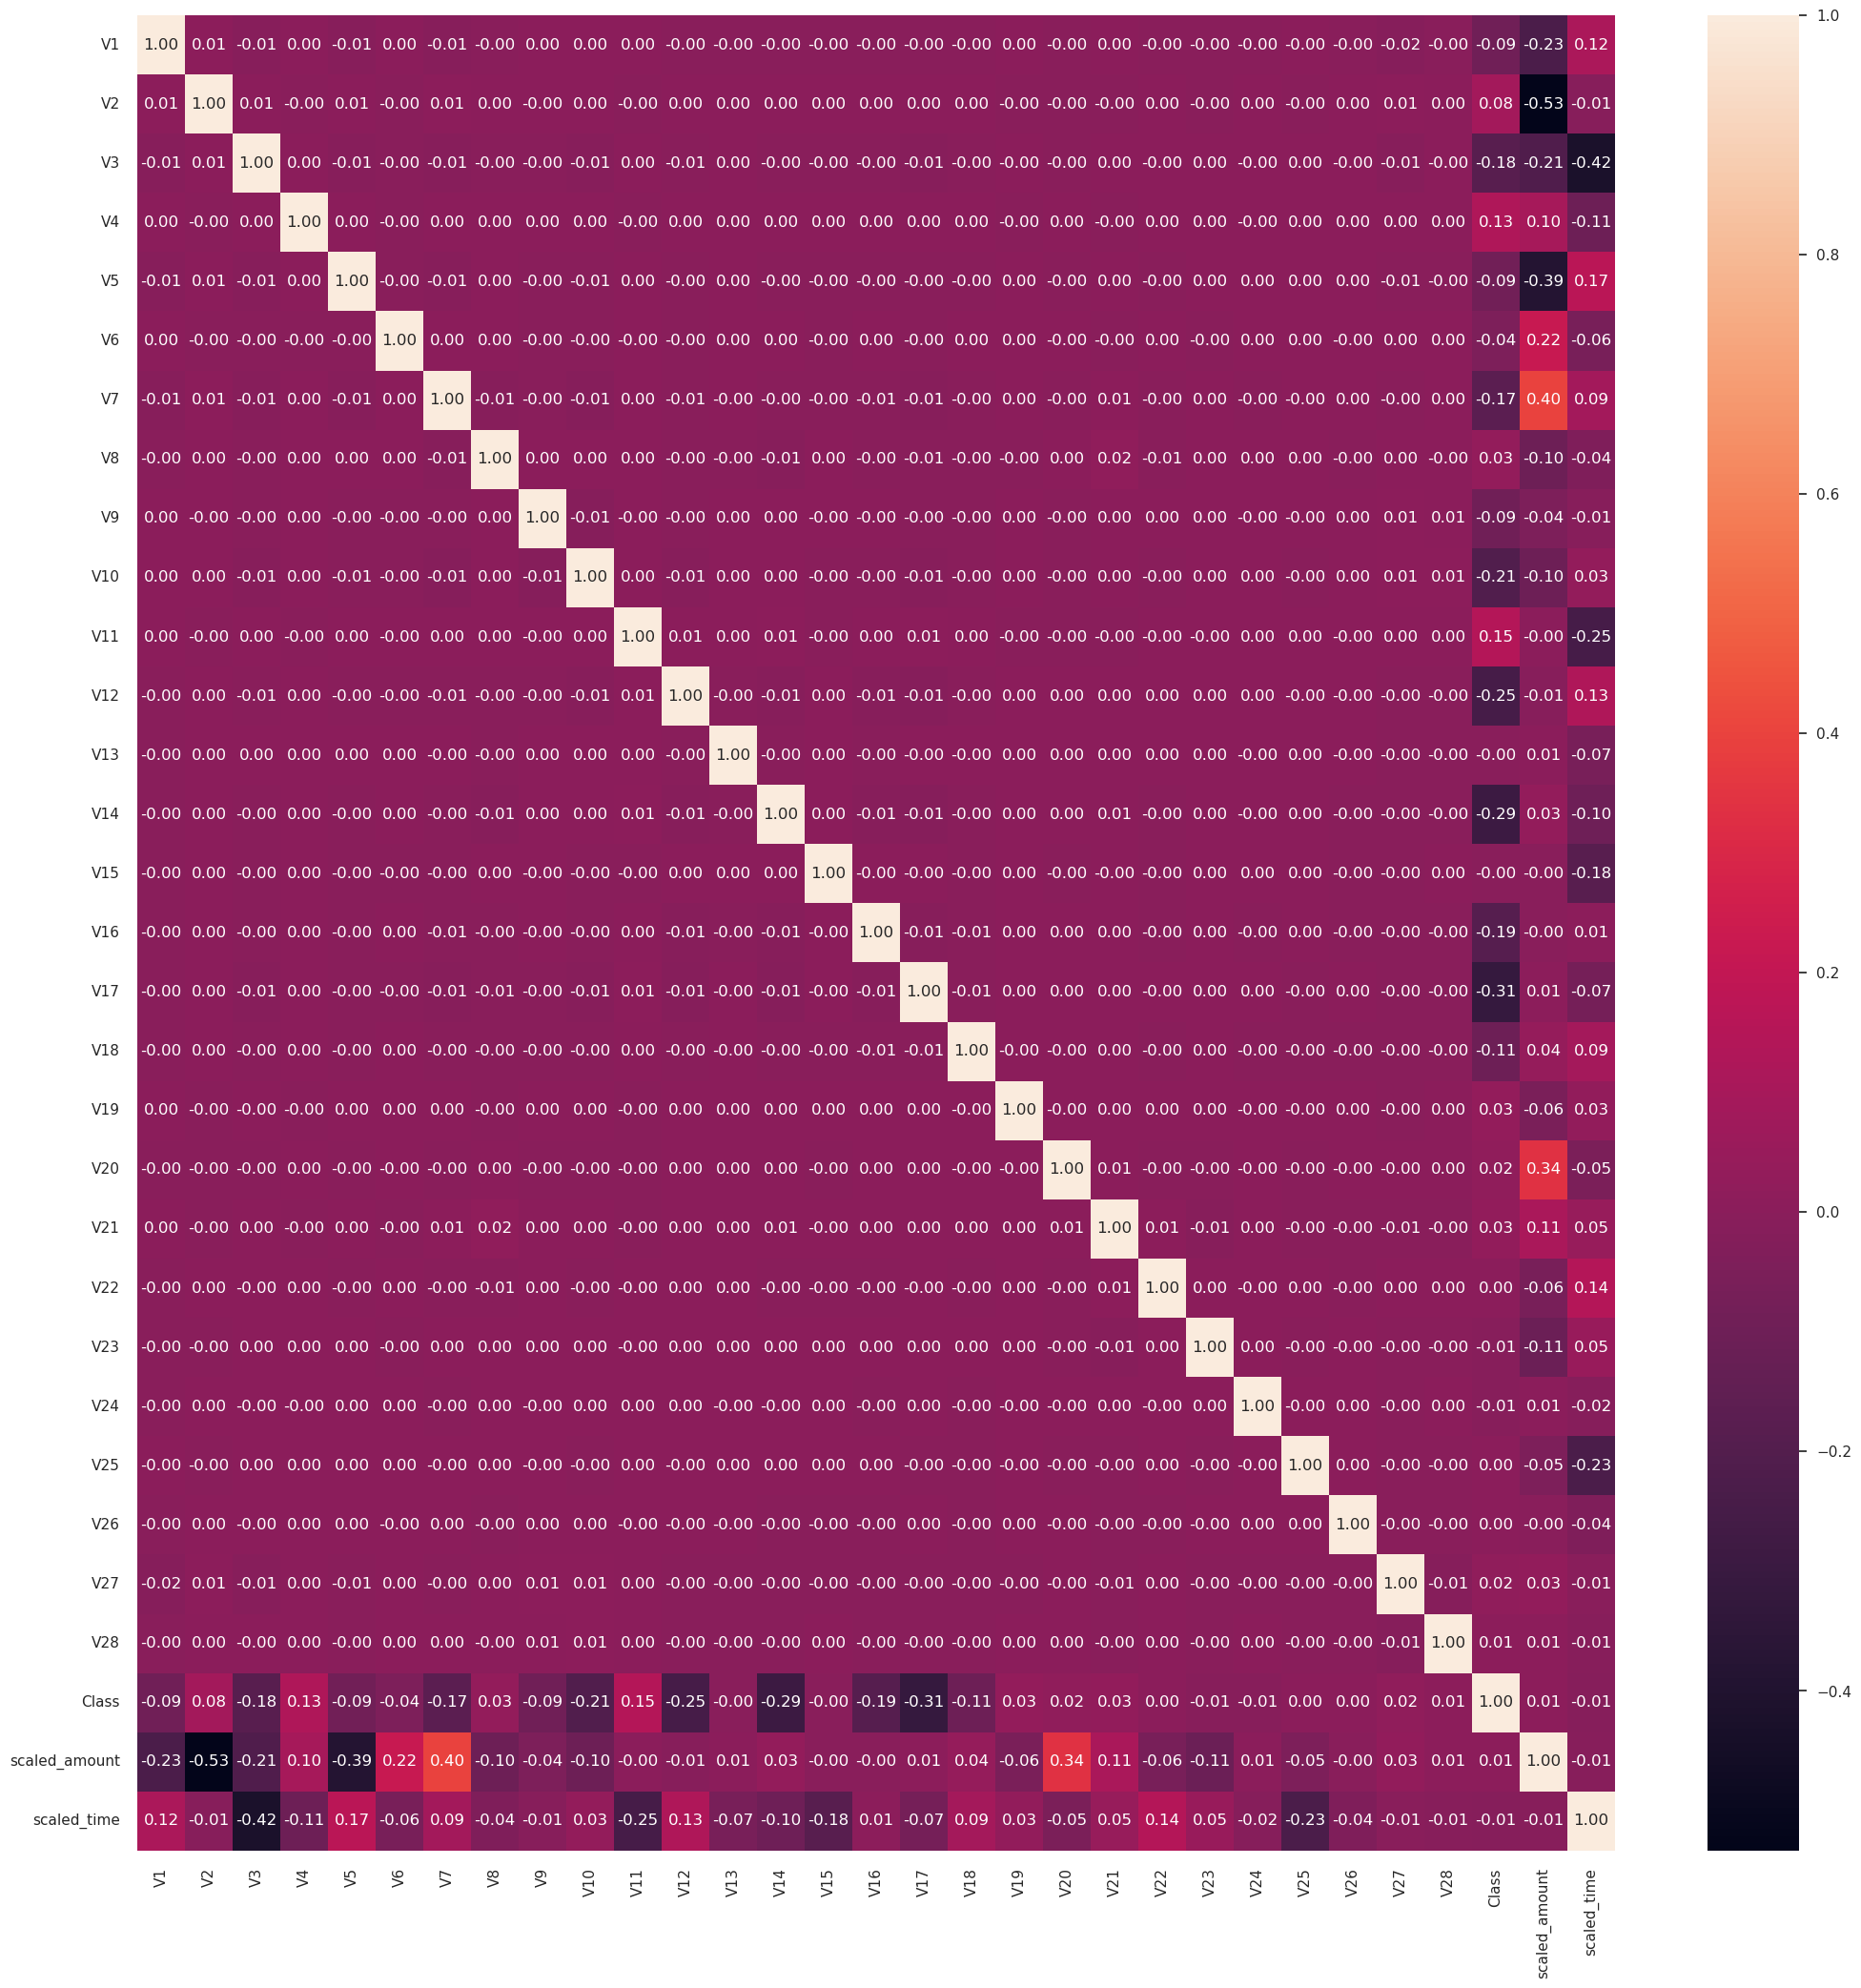

In [38]:
corr_matrix = df.corr()
plt.figure(figsize = (25,25))
ax = sns.heatmap(corr_matrix, annot=True,fmt='.2f')
plt.show()

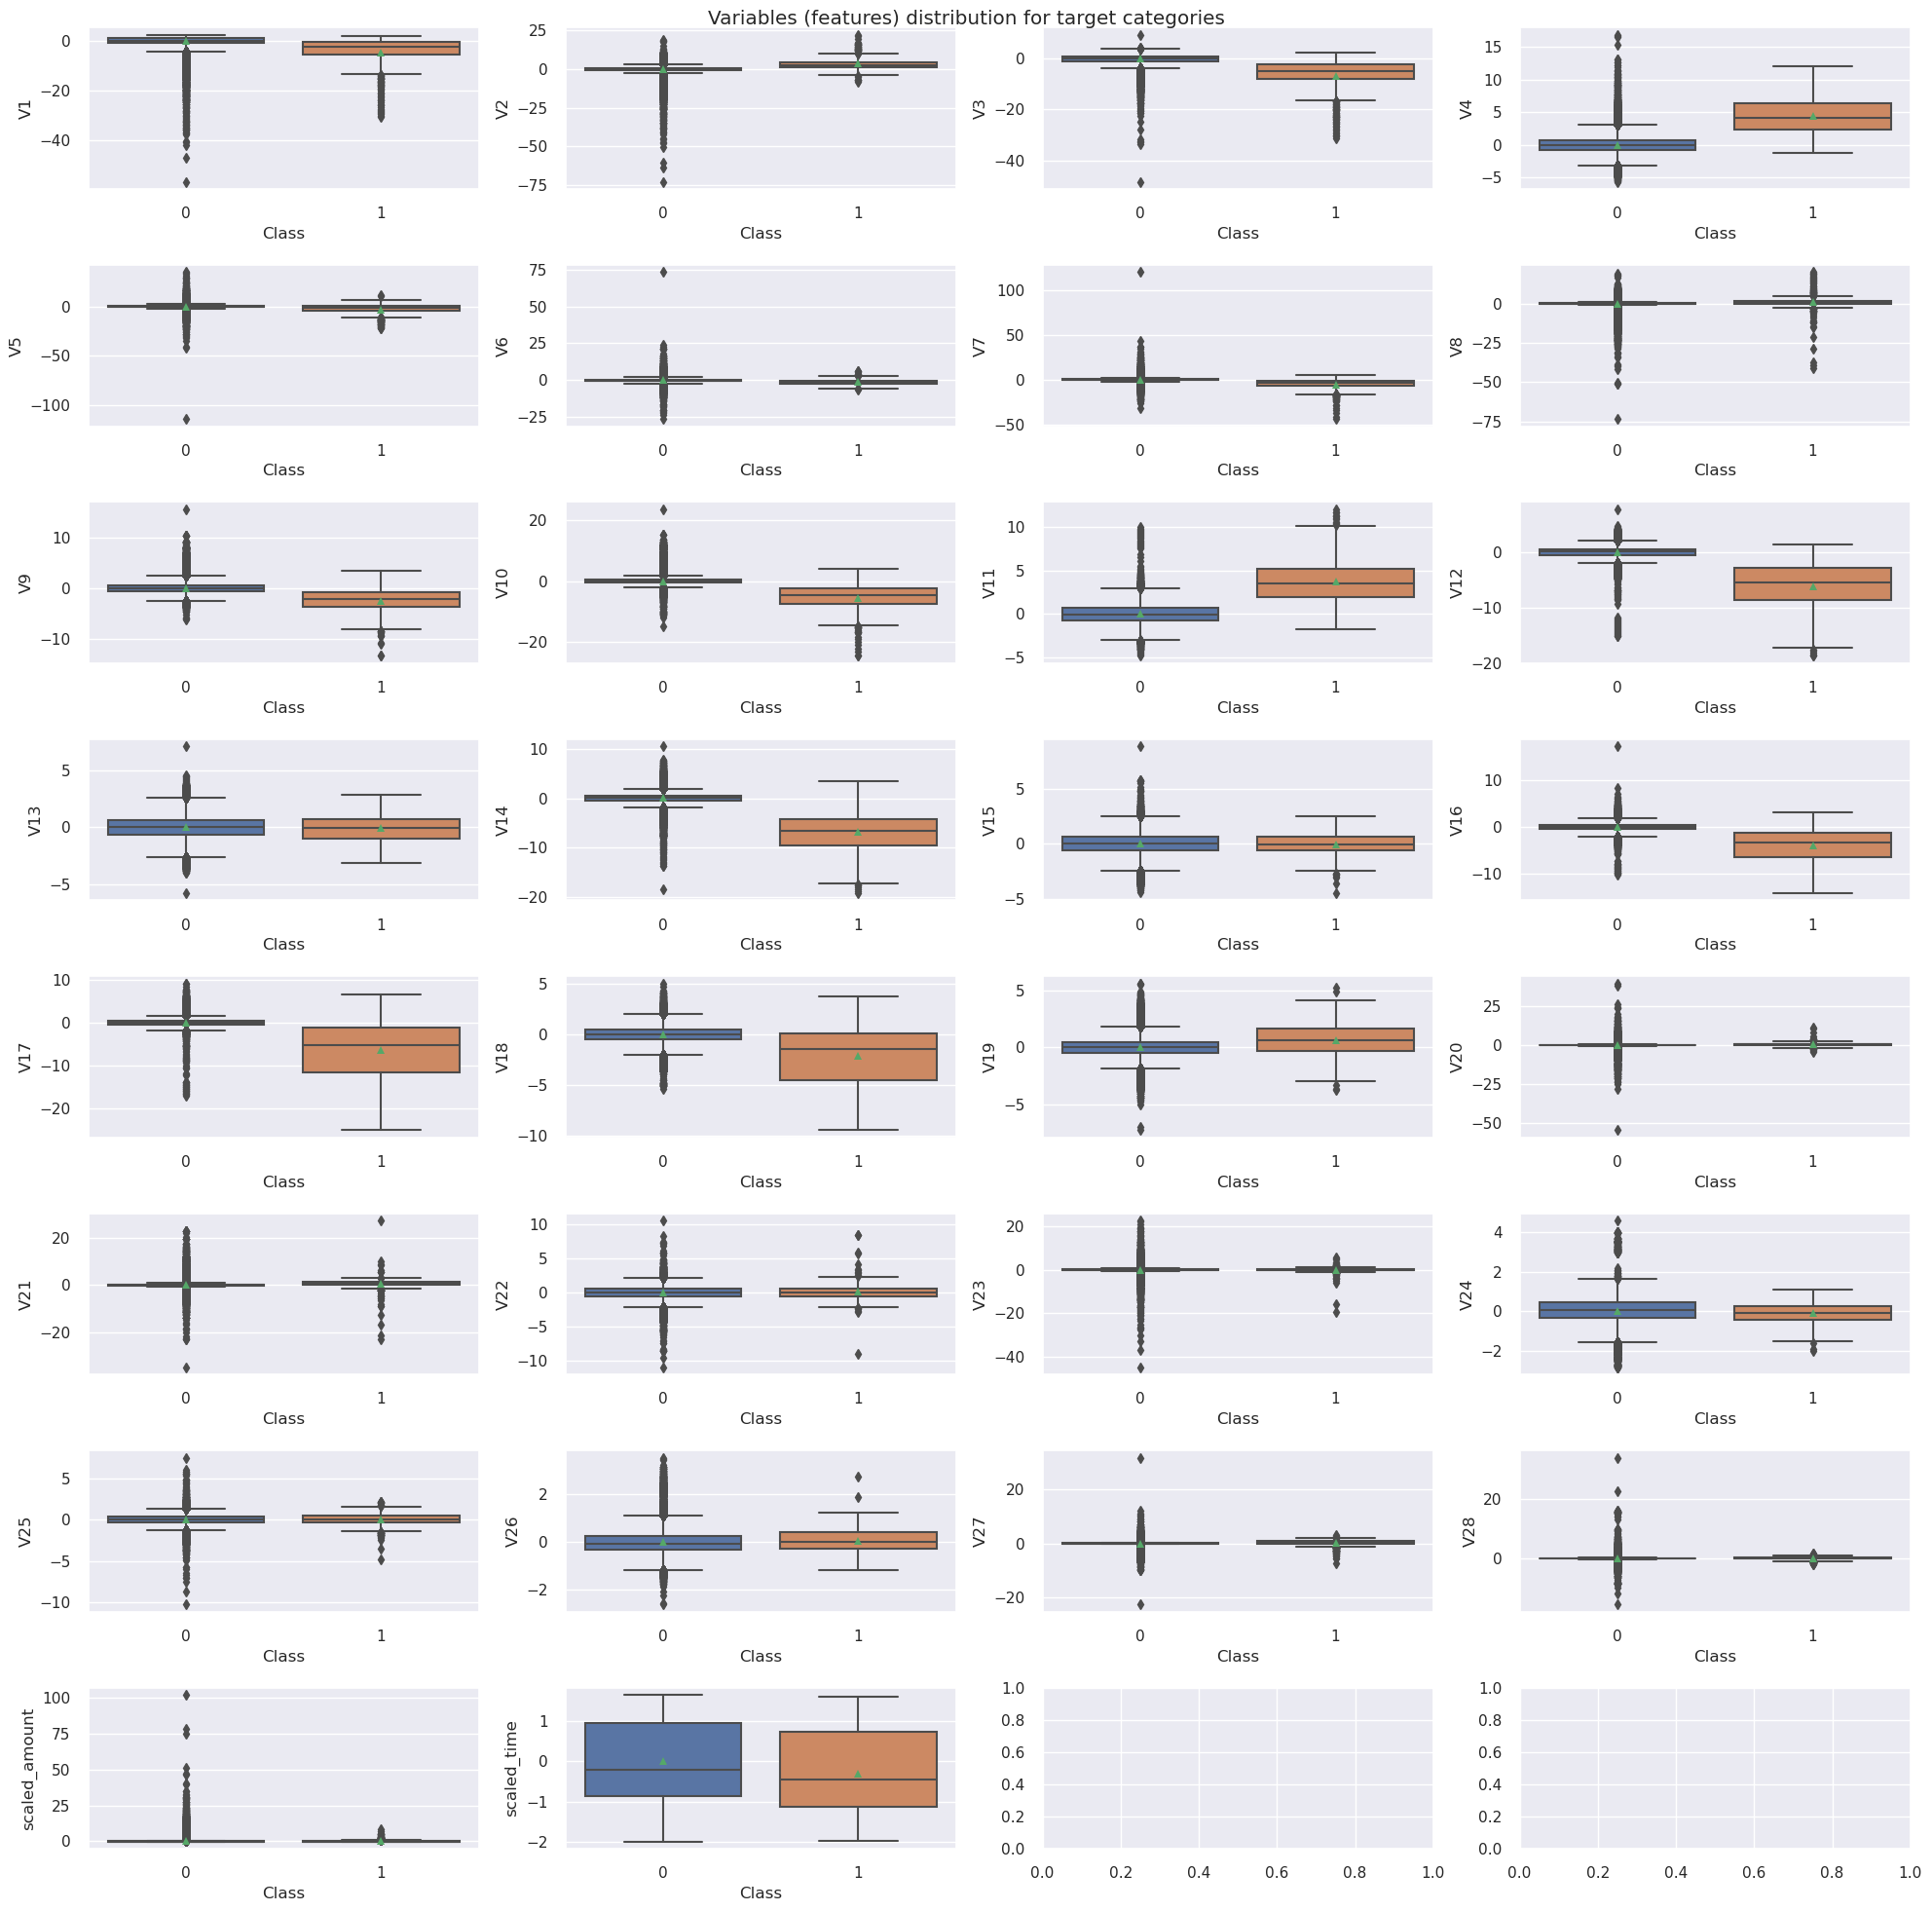

In [54]:
# Boxplots
features = list(df.loc[:, df.columns != 'Class'].columns)
target = 'Class'

def draw_boxplot(df, features, target):
    if len(features)%4 !=0:
        nrows = (len(df.columns)-1)//4+1
    else:
        nrows = (len(df.columns)-1)//4
    fig, axes = plt.subplots(nrows, 4,figsize=(20, 20))
    fig.suptitle(f'Variables (features) distribution for target categories')
    row=0
    i=0
    for feature in features:
            sns.boxplot(data=df, x=target, y=feature, showmeans=True, meanprops={"markeredgecolor": "yellow"},ax=axes[row,i])
            i += 1
            if i > 3:
                i = 0
                row += 1
    plt.tight_layout()
    plt.show()
    
draw_boxplot(df, features, target)

Podział zbioru i estymacja modelu

In [95]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    report_train = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{report_train}")
    print("------------------------------------------------------------------------")

    print("TESTING RESULTS: \n===============================")
    report_test = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{report_test}")


    plt.figure(figsize=(5,4))
    fx=sns.heatmap(confusion_matrix(y_test,y_test_pred), annot=True, fmt=".0f",cmap="GnBu")
    fx.set_title('Confusion Matrix (test results) \n');
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n');
    fx.xaxis.set_ticklabels(['0','1'])
    fx.yaxis.set_ticklabels(['0','1'])
    pass

In [92]:
X = df.drop('Class', axis=1)
y = df['Class']

In [93]:
# z uwagi na nierównomierny podział pomiędzy kategorie, stosuje funkcje 'stratify' przy podziale danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [94]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [126]:
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
# rf_sccore = cross_val_score(rf_classifier, X_train, y_train, cv=10).mean()
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[226602      0]
 [     1    377]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                       0           1  accuracy      macro avg   weighted avg
precision       0.999996    1.000000  0.999996       0.999998       0.999996
recall          1.000000    0.997354  0.999996       0.998677       0.999996
f1-score        0.999998    0.998675  0.999996       0.999337       0.999996
support    226602.000000  378.000000  0.999996  226980.000000  226980.000000
------------------------------------------------------------------------
TESTING RESULTS: 
CONFUSION MATRIX:
[[56650     1]
 [   26    69]]
ACCURACY SCORE:
0.9995
CLASSIFICATION REPORT:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999541   0.985714  0.999524      0.992628      0.999518
recall         0.999982   0.726316  0.999524      0.863149      0.999524
f1-score       0.999762   0.836364  0.999524      0.918063      0.999488
support    56651.000

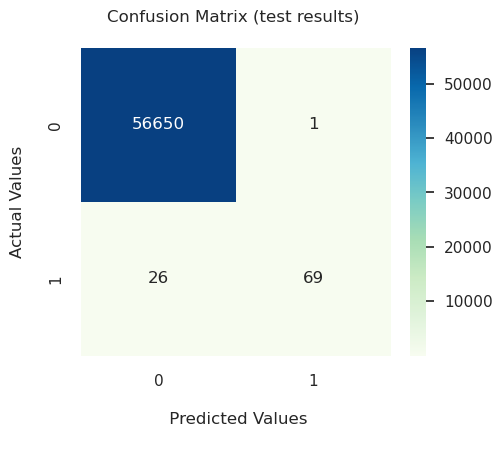

In [129]:
evaluate(rf_classifier, X_train, X_test, y_train, y_test)

In [125]:
tree_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)
# tree_score = cross_val_score(tree_classifier, X_train, y_train, cv=10, scoring='precision').mean()
tree_classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[226602      0]
 [     0    378]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                  0      1  accuracy  macro avg  weighted avg
precision       1.0    1.0       1.0        1.0           1.0
recall          1.0    1.0       1.0        1.0           1.0
f1-score        1.0    1.0       1.0        1.0           1.0
support    226602.0  378.0       1.0   226980.0      226980.0
------------------------------------------------------------------------
TESTING RESULTS: 
CONFUSION MATRIX:
[[56630    21]
 [   35    60]]
ACCURACY SCORE:
0.9990
CLASSIFICATION REPORT:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999382   0.740741  0.999013      0.870062      0.998949
recall         0.999629   0.631579  0.999013      0.815604      0.999013
f1-score       0.999506   0.681818  0.999013      0.840662      0.998974
support    56651.000000  95.000000  0.999013  56746.000000  56746.000000


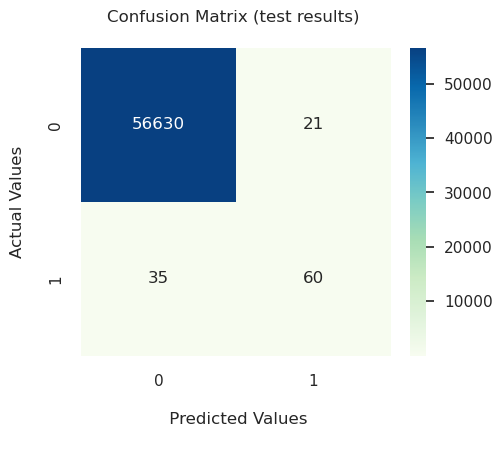

In [130]:
evaluate(tree_classifier, X_train, X_test, y_train, y_test)

* Przy zastosowaniu metody class_weighted='balanced' przy braku optymalizacji hiperparametrów otrzymujemy zadowalające wyniki - w przypadku RandomForestClassifier
  mamy tylko jedną fałszywie dodatnią obserwacje, co jest pożądane w zadanym zbiorze danych (większy koszt False Positive niż False Negative --metryką, którą chcemy zmaksymalizować jest w tym przypadku 'precision').
* Nieznaczne przetrenowanie obu modeli 

Ustalenie poziomu cut-off

Logit: ROC AUC = 0.9141


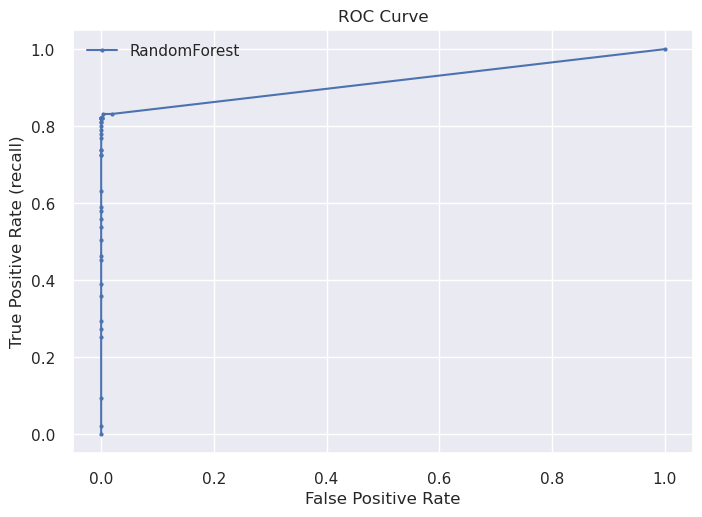

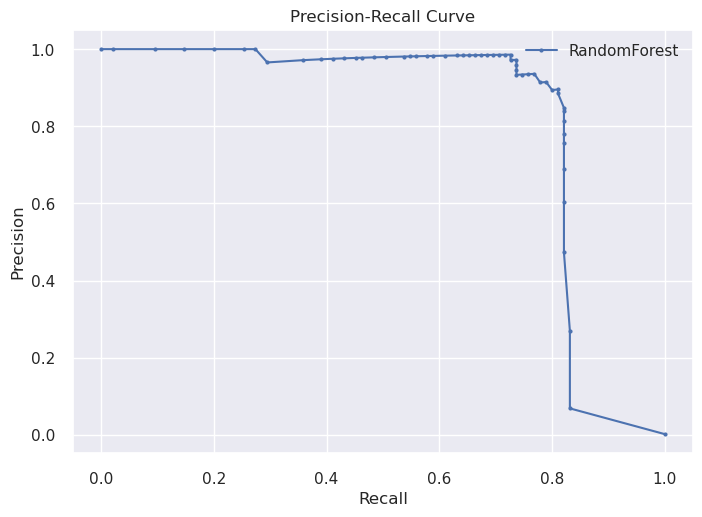

In [173]:
# from probability to class value based on custom threshold
def probs_to_prediction(probs, threshold):
    pred=[]
    for x in probs[:,1]:
        if x>threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

# getting predicted probability values
probability = rf_classifier.predict_proba(X_test)

# calculate ROC AUC score. AUC = 0.9794
print("Logit: ROC AUC = %.4f" % roc_auc_score(y_test, probability[:, 1]))

# calculate and plot the ROC curve
model_fpr, model_tpr, _ = roc_curve(y_test, probability[:, 1])
plt.plot(model_fpr, model_tpr, marker='.', label='RandomForest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.legend()
plt.title("ROC Curve")
plt.show()

# calculate and plot the Precision-Recall curve
model_precision, model_recall, thresholds = precision_recall_curve(y_test, probability[:, 1])
plt.plot(model_recall, model_precision, marker='.', label='RandomForest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

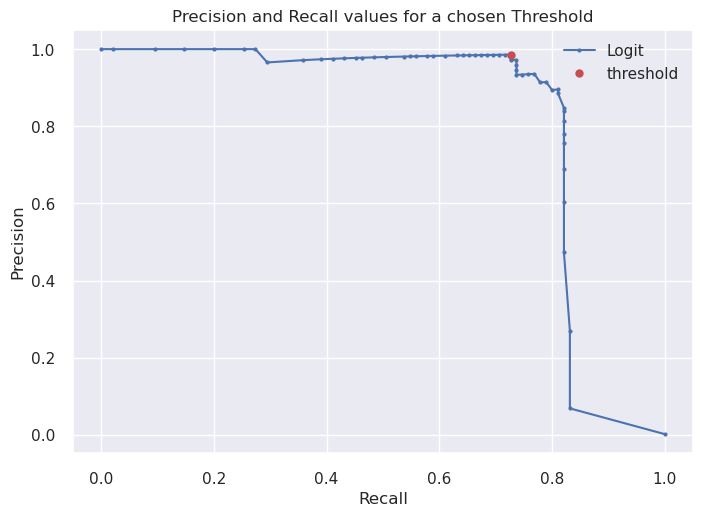

In [174]:
# plot the Precision-Recall curve with a threshold
plt.plot(model_recall, model_precision, marker='.', label='Logit')
plt.plot(model_recall[24], model_precision[24], "ro", label="threshold")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision and Recall values for a chosen Threshold')
plt.show()

In [175]:
def make_classification_score(y_test, predictions, modelName):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel() # ravel() used to convert to a 1-D array
    prec=precision_score(y_test, predictions)
    rec=recall_score(y_test, predictions)
    f1=f1_score(y_test, predictions)
    acc=accuracy_score(y_test, predictions)
    # specificity
    spec=tn/(tn+fp)

    score = {'Model': [modelName], 'Accuracy': [acc], 'f1': [f1], 'Recall': [rec], 'Precision': [prec], \
        'Specificity': [spec], 'TP': [tp], 'TN': [tn], 'FP': [fp], 'FN': [fn], 'y_test size': [len(y_test)]}
    df_score = pd.DataFrame(data=score)
    return df_score

In [176]:
# print the threshold value
print("Threshold value = %.4f" % thresholds[24])

# results with the chosen threshold
predictions = probs_to_prediction(probability, thresholds[24])
make_classification_score(y_test, predictions, "RandomForest")

Threshold value = 0.5100


,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,RandomForest,0.999507,0.829268,0.715789,0.985507,0.999982,68,56650,1,27,56746


Zadanie dodatkowe (BONUS)   
Fraud jest zdarzeniem rzadkim. Istnieją metody, które pozwalają na lepsze rozpoznanie tego typu zjawisk, mogą to być na przykład oversampling lub undersampling. Użyj jednej z tych metod.

In [179]:
df = df.sample(frac=1)

class_1 = df.loc[df['Class'] == 1]
class_0 = df.loc[df['Class'] == 0][:492]
new_df = pd.concat([class_0, class_1])
df2 = new_df.sample(frac=1, random_state=42)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 965 entries, 57470 to 195075
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   V1             965 non-null    float64
 1   V2             965 non-null    float64
 2   V3             965 non-null    float64
 3   V4             965 non-null    float64
 4   V5             965 non-null    float64
 5   V6             965 non-null    float64
 6   V7             965 non-null    float64
 7   V8             965 non-null    float64
 8   V9             965 non-null    float64
 9   V10            965 non-null    float64
 10  V11            965 non-null    float64
 11  V12            965 non-null    float64
 12  V13            965 non-null    float64
 13  V14            965 non-null    float64
 14  V15            965 non-null    float64
 15  V16            965 non-null    float64
 16  V17            965 non-null    float64
 17  V18            965 non-null    float64
 18  V19

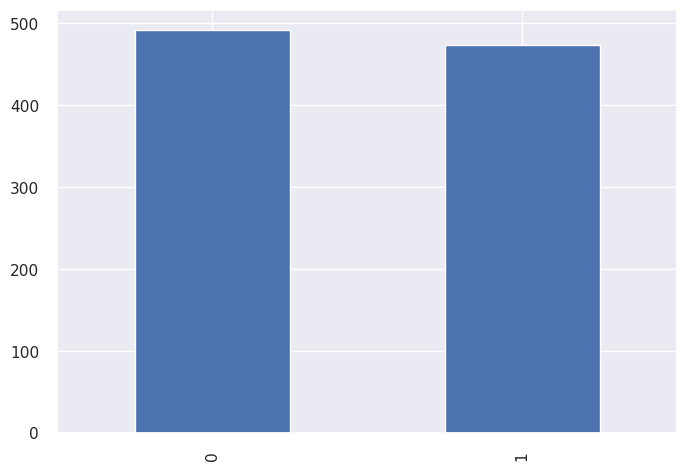

In [183]:
df2['Class'].value_counts().plot(kind="bar")
plt.show()

In [184]:
X = df2.drop('Class', axis=1)
y = df2['Class']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [188]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_sccore = cross_val_score(rf_classifier, X_train, y_train, cv=10).mean()
# rf_classifier.fit(X_train,y_train)

In [192]:
cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_classifier_kfold = RandomForestClassifier(random_state=42)
sc_kfold = cross_val_score(rf_classifier_kfold, X_train, y_train, cv=cv_kfold, scoring='precision')
rf_classifier_kfold.fit(X_train, y_train)
print(np.mean(sc_kfold))

0.9641645526805342


In [196]:
param_grid = {"max_depth": [5, 10, None],
              "max_features": list(range(1,6)),
              "n_estimators": [10, 50, 100, 200],
              "min_samples_leaf": [1, 3, 5]}

In [197]:
random_search = RandomizedSearchCV(rf_classifier,
                                   param_distributions=param_grid,
                                   cv=5,
                                   n_iter=20,
                                   verbose=1, 
                                   scoring='precision',
                                   random_state=42)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [5, 10, None],
                                        'max_features': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [1, 3, 5],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=42, scoring='precision', verbose=1)

In [198]:
random_search.best_params_

{'n_estimators': 50,
 'min_samples_leaf': 5,
 'max_features': 3,
 'max_depth': None}

In [199]:
random_search.best_score_

0.9770748337192631

In [201]:
rf_optimized = random_search.best_estimator_

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[389   2]
 [ 27 354]]
ACCURACY SCORE:
0.9624
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.935096    0.994382  0.962435    0.964739      0.964355
recall       0.994885    0.929134  0.962435    0.962009      0.962435
f1-score     0.964064    0.960651  0.962435    0.962358      0.962380
support    391.000000  381.000000  0.962435  772.000000    772.000000
------------------------------------------------------------------------
TESTING RESULTS: 
CONFUSION MATRIX:
[[99  2]
 [ 8 84]]
ACCURACY SCORE:
0.9482
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.925234   0.976744  0.948187    0.950989      0.949788
recall       0.980198   0.913043  0.948187    0.946621      0.948187
f1-score     0.951923   0.943820  0.948187    0.947872      0.948061
support    101.000000  92.000000  0.948187  193.000000    193.000000


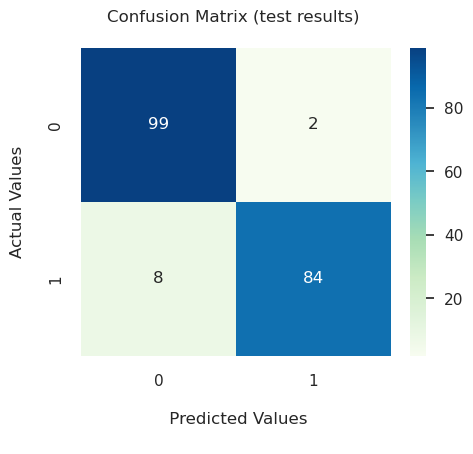

In [202]:
evaluate(rf_optimized, X_train, X_test, y_train, y_test)